In [1]:
import numpy as np, uproot as ur, awkward as ak, pandas as pd
import matplotlib.pyplot as plt
import os, sys
import pickle
import scipy.stats as st
from collections import defaultdict
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from scipy.stats import poisson, norm
from scipy.spatial import ConvexHull
import fnmatch


import mplhep as hep
plt.figure()
hep.style.use("CMS")
plt.close()

def gaus(x, amp, mean, sigma):
    return amp * np.exp( -(x - mean)**2 / (2*sigma**2) ) 

def phi_reconstruct(x, y, z):
    return np.degrees(np.arctan2(y, x))
    
def theta_reconstruct(x, y, z):
    return np.degrees(np.arccos(abs(z)/np.sqrt(x**2+y**2+z**2)))

def vector_angle_reconstruct(x, y, z):
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    
    theta = theta_reconstruct(x_vec, y_vec, z_vec)
    phi = phi_reconstruct(x_vec, y_vec, z_vec)
    
    return theta, phi


In [2]:
#output_file = free_file.replace(".root", ".pkl")
path = '/home/jiajun/muography/data/testing/'
files = sorted(os.listdir(path))

In [45]:
for config in ['free','target']:

    batches = pd.DataFrame()
    output_file = f'{config}_merge.pkl'
    for file in files:
        if 'merge' in file: continue
        if config not in file: continue
    
        with ur.open(path+file+":events") as f:
            arrays = f.arrays(filter_name=["MuographyHits.energy", "MuographyHitsContributions.time", 
                                           "MuographyHits.position.x", "MuographyHits.position.y", "MuographyHits.position.z", 
                                           "MCParticles.PDG", "MCParticles.generatorStatus", 
                                           "MCParticles.momentum.x", "MCParticles.momentum.y", "MCParticles.momentum.z", 
                                           "MCParticles.vertex.x", "MCParticles.vertex.y", "MCParticles.vertex.z", 
                                           "MCParticles.mass"])
            
        y,x=np.histogram(ak.flatten(arrays["MuographyHits.energy"]), bins=100, range=(0, 0.004))
        bc=(x[1:]+x[:-1])/2
        MIP=list(bc[y==max(y[3:])])[0] 
        plt.errorbar(np.array(bc)*1000,np.array(y),yerr=np.sqrt(y))
        plt.axvline(0.2*MIP*1000,label=f'MIP = {MIP*1000:.2f} MeV')
        plt.xlabel('Cell Energy (MeV)')
        plt.legend()
        plt.close()
        
        data_energy = arrays[f'MuographyHits.energy']
        
        sigma = 0.56
        
        # flatten to numpy
        flat = ak.to_numpy(data_energy.layout.content)
        noise = np.random.normal(0, sigma, size=len(flat))*MIP
        
        # add noise
        flat_smear = np.clip(flat + noise, a_min=1e-16, a_max=None)
        
        offsets = ak.to_numpy(data_energy.layout.offsets)  # convert Index64 → numpy
        lengths = offsets[1:] - offsets[:-1]
        data_energy_smear = ak.unflatten(flat_smear, lengths)
        
        data_MIP_cut = data_energy_smear > 0.2*MIP
        data_cell_cut = ak.num(arrays[f'MuographyHits.energy'], axis=1) >= 2
        
        data_energy = data_energy[data_cell_cut]
        data_energy_smear = data_energy_smear[data_cell_cut]
        data_x = arrays[f'MuographyHits.position.x'][data_cell_cut]
        data_y = arrays[f'MuographyHits.position.y'][data_cell_cut]
        data_z = arrays[f'MuographyHits.position.z'][data_cell_cut]    
        reco_data_angle = np.array([vector_angle_reconstruct(np.array(xi,dtype=float), np.array(yi,dtype=float), np.array(zi,dtype=float)) for xi, yi, zi in zip(data_x,data_y,data_z)])
        data_theta = ak.Array(reco_data_angle[:,0])
        data_phi = ak.Array(reco_data_angle[:,1])
        data_time = arrays[f'MuographyHitsContributions.time'][data_cell_cut]
        status = arrays["MCParticles.generatorStatus"]
        mc_px = arrays["MCParticles.momentum.x"][status==1][data_cell_cut]
        mc_py = arrays["MCParticles.momentum.y"][status==1][data_cell_cut]
        mc_pz = arrays["MCParticles.momentum.z"][status==1][data_cell_cut]
        mc_x = arrays["MCParticles.vertex.x"][status==1][data_cell_cut]
        mc_y = arrays["MCParticles.vertex.y"][status==1][data_cell_cut]
        mc_z = arrays["MCParticles.vertex.z"][status==1][data_cell_cut]
        mc_theta = theta_reconstruct(mc_px,mc_py,mc_pz)
        mc_phi = phi_reconstruct(mc_px,mc_py,mc_pz)
        mc_PDG = arrays["MCParticles.PDG"][status==1][data_cell_cut]
        mc_mass = arrays["MCParticles.mass"][status==1][data_cell_cut]
        status = status[status==1][data_cell_cut]
        detector = np.full(len(status), int(file.split('_')[3]), dtype=np.int32)
        data_energy_sum = np.sum(data_energy_smear,axis=1)
        
        H, xedges, yedges = np.histogram2d(
            np.array(np.concatenate(mc_theta)),
            np.array(data_energy_sum),
            bins=(200, np.linspace(0,15/1000,200))
        )
        
        X, Y = np.meshgrid(xedges, yedges)
        
        plt.pcolormesh(X, Y, H.T, cmap="copper")
        plt.colorbar(label='Counts')
        plt.xlabel("MC Theta (degrees)")
        plt.ylabel('Sum Event Energy (MeV)')
        #plt.yscale('log')
        
        
        peak_indices = np.argmax(H, axis=1)
        theta_centers = 0.5 * (xedges[:-1] + xedges[1:])
        energy_centers = 0.5 * (yedges[:-1] + yedges[1:])
        E_peaks = energy_centers[peak_indices]
        def exp_decay(theta, A, k, C):
            return A * np.exp(-k * theta) + C
        # Remove NaNs or weird edges
        mask = np.isfinite(E_peaks)
        theta_fit = theta_centers[mask]
        E_fit = E_peaks[mask]
        
        popt, pcov = curve_fit(exp_decay, theta_fit, E_fit, p0=(10, 0.05, 0),sigma=1/E_fit)
        A, k, C = popt
        #print("Fit parameters: A=%.3f, k=%.3f, C=%.3f" % (A, k, C))
        theta_smooth = np.linspace(theta_fit.min(), theta_fit.max(), 300)
        plt.plot(theta_smooth, exp_decay(theta_smooth, *popt), '--', lw=2, label="Exp Fit: A=%.3f, B=%.3f, C=%.3f" % (A, k, C))
        legend = plt.legend(facecolor="black", edgecolor="white")
        for text in legend.get_texts():
            text.set_color("white")
        def theta_from_energy(E, A, k, C):
            return -(1.0 / k) * np.log((E - C) / A)
        plt.close()
        
        data_theta_engergy = theta_from_energy(np.array(data_energy_sum),*popt)
            
        branches = {
            "detector": ak.Array(detector),
            "theta_reco": ak.Array(data_theta),
            "phi_reco": ak.Array(data_phi),
            "theta_true": ak.Array(ak.flatten(mc_theta)),
            "phi_true": ak.Array(ak.flatten(mc_phi)),
            "event_energy": ak.Array(data_energy_sum),
            "theta_energy": ak.Array(data_theta_engergy)
        }   
        batch = pd.DataFrame(branches)
        
        batches = pd.concat([batches, batch], ignore_index=True)
        
        num = 10000
        for i in range(int(len(mc_theta)/num)):
            print(f"Processing {file}: {i}/{int(len(mc_theta)/num)-1}", end='\r',flush=True)
            branches = {
                "MuographyHits.position.x": data_x[i*num:(i+1)*num],
                "MuographyHits.position.y": data_y[i*num:(i+1)*num],
                "MuographyHits.position.z": data_z[i*num:(i+1)*num],
                "MuographyHits.time": data_time[i*num:(i+1)*num],
                "MuographyHits.energy_nonsmear": data_energy[i*num:(i+1)*num],
                "MuographyHits.energy": data_energy_smear[i*num:(i+1)*num],
                "MCParticles.generatorStatus": status[i*num:(i+1)*num],
                "MCParticles.PDG": mc_PDG[i*num:(i+1)*num],
                "MCParticles.mass": mc_mass[i*num:(i+1)*num],
                "MCParticles.momentum.x": mc_px[i*num:(i+1)*num],
                "MCParticles.momentum.y": mc_py[i*num:(i+1)*num],
                "MCParticles.momentum.z": mc_pz[i*num:(i+1)*num]
            }
            with ur.recreate(path+f'split/{file}_{i:03d}.root') as fout:
                fout["events"] = branches
        if len(mc_theta)%10000 != 0:
            print(f"Processing {file}: {i+1}/{int(len(mc_theta)/num)}", end='\r',flush=True)
            branches = {
                "MuographyHits.position.x": data_x[(i+1)*num:len(mc_theta)],
                "MuographyHits.position.y": data_y[(i+1)*num:len(mc_theta)],
                "MuographyHits.position.z": data_z[(i+1)*num:len(mc_theta)],
                "MuographyHits.time": data_time[(i+1)*num:len(mc_theta)],
                "MuographyHits.energy_nonsmear": data_energy[(i+1)*num:len(mc_theta)],
                "MuographyHits.energy": data_energy_smear[(i+1)*num:len(mc_theta)],
                "MCParticles.generatorStatus": status[(i+1)*num:len(mc_theta)],
                "MCParticles.PDG": mc_PDG[(i+1)*num:len(mc_theta)],
                "MCParticles.mass": mc_mass[(i+1)*num:len(mc_theta)],
                "MCParticles.momentum.x": mc_px[(i+1)*num:len(mc_theta)],
                "MCParticles.momentum.y": mc_py[(i+1)*num:len(mc_theta)],
                "MCParticles.momentum.z": mc_pz[(i+1)*num:len(mc_theta)]
            }
        
            with ur.recreate(path+f'split/{file}_{i+1:03d}.root') as fout:
                fout["events"] = branches
        
        
        
    with open(path+output_file, "wb") as fout:
        pickle.dump(batches, fout)
    print('/nDone' + f'for {config}' + '/n')

Processing four_detector_free_0_2.root: 5/16

/tmp/ipykernel_2076141/1807676791.py:103: RuntimeWarning: invalid value encountered in log
  return -(1.0 / k) * np.log((E - C) / A)


Processing four_detector_free_1_2.root: 5/617

/tmp/ipykernel_2076141/1807676791.py:103: RuntimeWarning: invalid value encountered in log
  return -(1.0 / k) * np.log((E - C) / A)


Processing four_detector_free_2_2.root: 3/3

/tmp/ipykernel_2076141/1807676791.py:103: RuntimeWarning: invalid value encountered in log
  return -(1.0 / k) * np.log((E - C) / A)


Processing four_detector_free_3_2.root: 1/1

/tmp/ipykernel_2076141/1807676791.py:103: RuntimeWarning: invalid value encountered in log
  return -(1.0 / k) * np.log((E - C) / A)


/nDone for free/n
Processing four_detector_target_0_2.root: 5/16

/tmp/ipykernel_2076141/1807676791.py:103: RuntimeWarning: invalid value encountered in log
  return -(1.0 / k) * np.log((E - C) / A)


Processing four_detector_target_1_2.root: 5/617

/tmp/ipykernel_2076141/1807676791.py:103: RuntimeWarning: invalid value encountered in log
  return -(1.0 / k) * np.log((E - C) / A)


Processing four_detector_target_2_2.root: 3/3

/tmp/ipykernel_2076141/1807676791.py:103: RuntimeWarning: invalid value encountered in log
  return -(1.0 / k) * np.log((E - C) / A)


/nDone for target/nector_target_3_2.root: 1/1


/tmp/ipykernel_2076141/1807676791.py:103: RuntimeWarning: invalid value encountered in log
  return -(1.0 / k) * np.log((E - C) / A)


In [4]:
# Will likely need to change name of npz file for your use case
npz_unpacked = np.load(path+"/predictions_appended_test.npz", allow_pickle=True) 

predictions_unnormalized = npz_unpacked['outputs_scaled'].item()
targets_unnormalized = npz_unpacked['targets_scaled'].item()
predictions = npz_unpacked['outputs'].item()
targets = npz_unpacked['targets'].item()
meta = npz_unpacked['meta']

targets_theta = np.degrees(targets_unnormalized["theta"])
targets_phi = np.degrees(targets_unnormalized["phi"])
predictions_theta = np.degrees(predictions_unnormalized["theta"])
predictions_phi = np.degrees(predictions_unnormalized["phi"])

In [116]:
file_and_eventnumber_to_index = {}
file_names = meta[:, 0]
unique_file_names = np.unique(file_names)
for unique_name in unique_file_names:
    file_and_eventnumber_to_index[unique_name] = {}
for i, (file_name, event_number, particle_type) in enumerate(meta):
    file_and_eventnumber_to_index[file_name][event_number] = i


# Regex to split base and last number
pattern = re.compile(r'(.+?)_(\d+)\.root$')

# Keep only files that match
matching_files = [f for f in unique_file_names if pattern.search(f)]

# Sort first by base, then by last number
sorted_files = sorted(
    matching_files, 
    key=lambda f: (
        pattern.search(f).group(1),          # base part
        int(pattern.search(f).group(2))      # last number
    )
)

In [125]:
output_data = {}
for i, file_name in enumerate(sorted_files):
    if 'free' not in file_name: continue
    num_events = len(meta[:,0][meta[:,0]==file_name])
    gnn_preds, gnn_truths = [], []
    for event_number in range(num_events):
        # Find the global index for this (file, event_number)
        idx = file_and_eventnumber_to_index[file_name].get(f"{int(event_number)}", None)
        if idx is None:
            gnn_preds.append(None)
            #gnn_truths.append(None)# skip if event isn't in meta_info
        
        gnn_preds.append(predictions_theta[idx])
        #gnn_truths.append(GNN_truth[idx])
    output_data[f"{file_name.split('/')[-1]}"] = ak.Array(gnn_preds)
    #output_data["GNN_true_theta"] = ak.Array(gnn_truths)

In [133]:
flattened = np.concatenate([arr for arr in output_data.values()])

In [135]:
dg['GNN_theta'] = flattened

In [137]:
dg

,detector,theta_reco,phi_reco,theta_true,phi_true,event_energy,theta_energy,GNN_theta
0,0,33.500357,71.155511,39.802012,59.988974,0.002496,44.018874,31.403015
1,0,48.451311,112.500000,36.276711,116.456960,0.003104,36.008263,37.085255
2,0,26.153173,-157.500000,30.339367,-150.249913,0.006179,17.528586,22.704494
3,0,67.870069,112.500000,74.176018,-43.531968,0.001122,NaN,55.041126
4,0,32.736450,-90.000000,43.858596,-101.505043,0.003259,34.436134,32.830730
...,...,...,...,...,...,...,...,...
295989,3,38.587140,22.500000,36.137578,39.115665,0.003012,42.215763,16.534536
295990,3,48.450156,-0.000000,34.955609,21.153486,0.006236,18.326757,13.456107
295991,3,34.383715,-135.000000,45.440004,-141.175488,0.003059,41.519185,16.530048
295992,3,14.957216,90.000000,15.428585,92.079096,0.007204,14.682284,12.714511


In [121]:
import pandas as pd
df = pd.read_pickle('/home/jiajun/muography/data/testing/target_merge.pkl')
df

,detector,theta_reco,phi_reco,theta_true,phi_true,event_energy,theta_energy
0,0,33.500357,7.115551e+01,39.802012,59.988974,0.004335,29.418326
1,0,48.451311,1.125000e+02,36.276711,116.456960,0.003769,33.202438
2,0,26.153173,-1.575000e+02,30.339367,-150.249913,0.003903,32.246491
3,0,67.870069,1.125000e+02,74.176018,-43.531968,0.001777,56.171318
4,0,32.736450,-9.000000e+01,43.858596,-101.505043,0.004570,28.015038
...,...,...,...,...,...,...,...
304041,3,20.474850,1.350000e+02,21.488313,120.576809,0.003342,36.590279
304042,3,32.737813,1.125000e+02,34.096607,127.223308,0.004434,27.092439
304043,3,41.269214,-2.250000e+01,54.373083,-36.577887,0.000862,NaN
304044,3,25.820993,1.575000e+02,28.608662,134.474046,0.004071,29.714452


In [122]:
import pandas as pd
dg = pd.read_pickle('/home/jiajun/muography/data/testing/free_merge.pkl')
dg

,detector,theta_reco,phi_reco,theta_true,phi_true,event_energy,theta_energy
0,0,33.500357,71.155511,39.802012,59.988974,0.002496,44.018874
1,0,48.451311,112.500000,36.276711,116.456960,0.003104,36.008263
2,0,26.153173,-157.500000,30.339367,-150.249913,0.006179,17.528586
3,0,67.870069,112.500000,74.176018,-43.531968,0.001122,NaN
4,0,32.736450,-90.000000,43.858596,-101.505043,0.003259,34.436134
...,...,...,...,...,...,...,...
295989,3,38.587140,22.500000,36.137578,39.115665,0.003012,42.215763
295990,3,48.450156,-0.000000,34.955609,21.153486,0.006236,18.326757
295991,3,34.383715,-135.000000,45.440004,-141.175488,0.003059,41.519185
295992,3,14.957216,90.000000,15.428585,92.079096,0.007204,14.682284


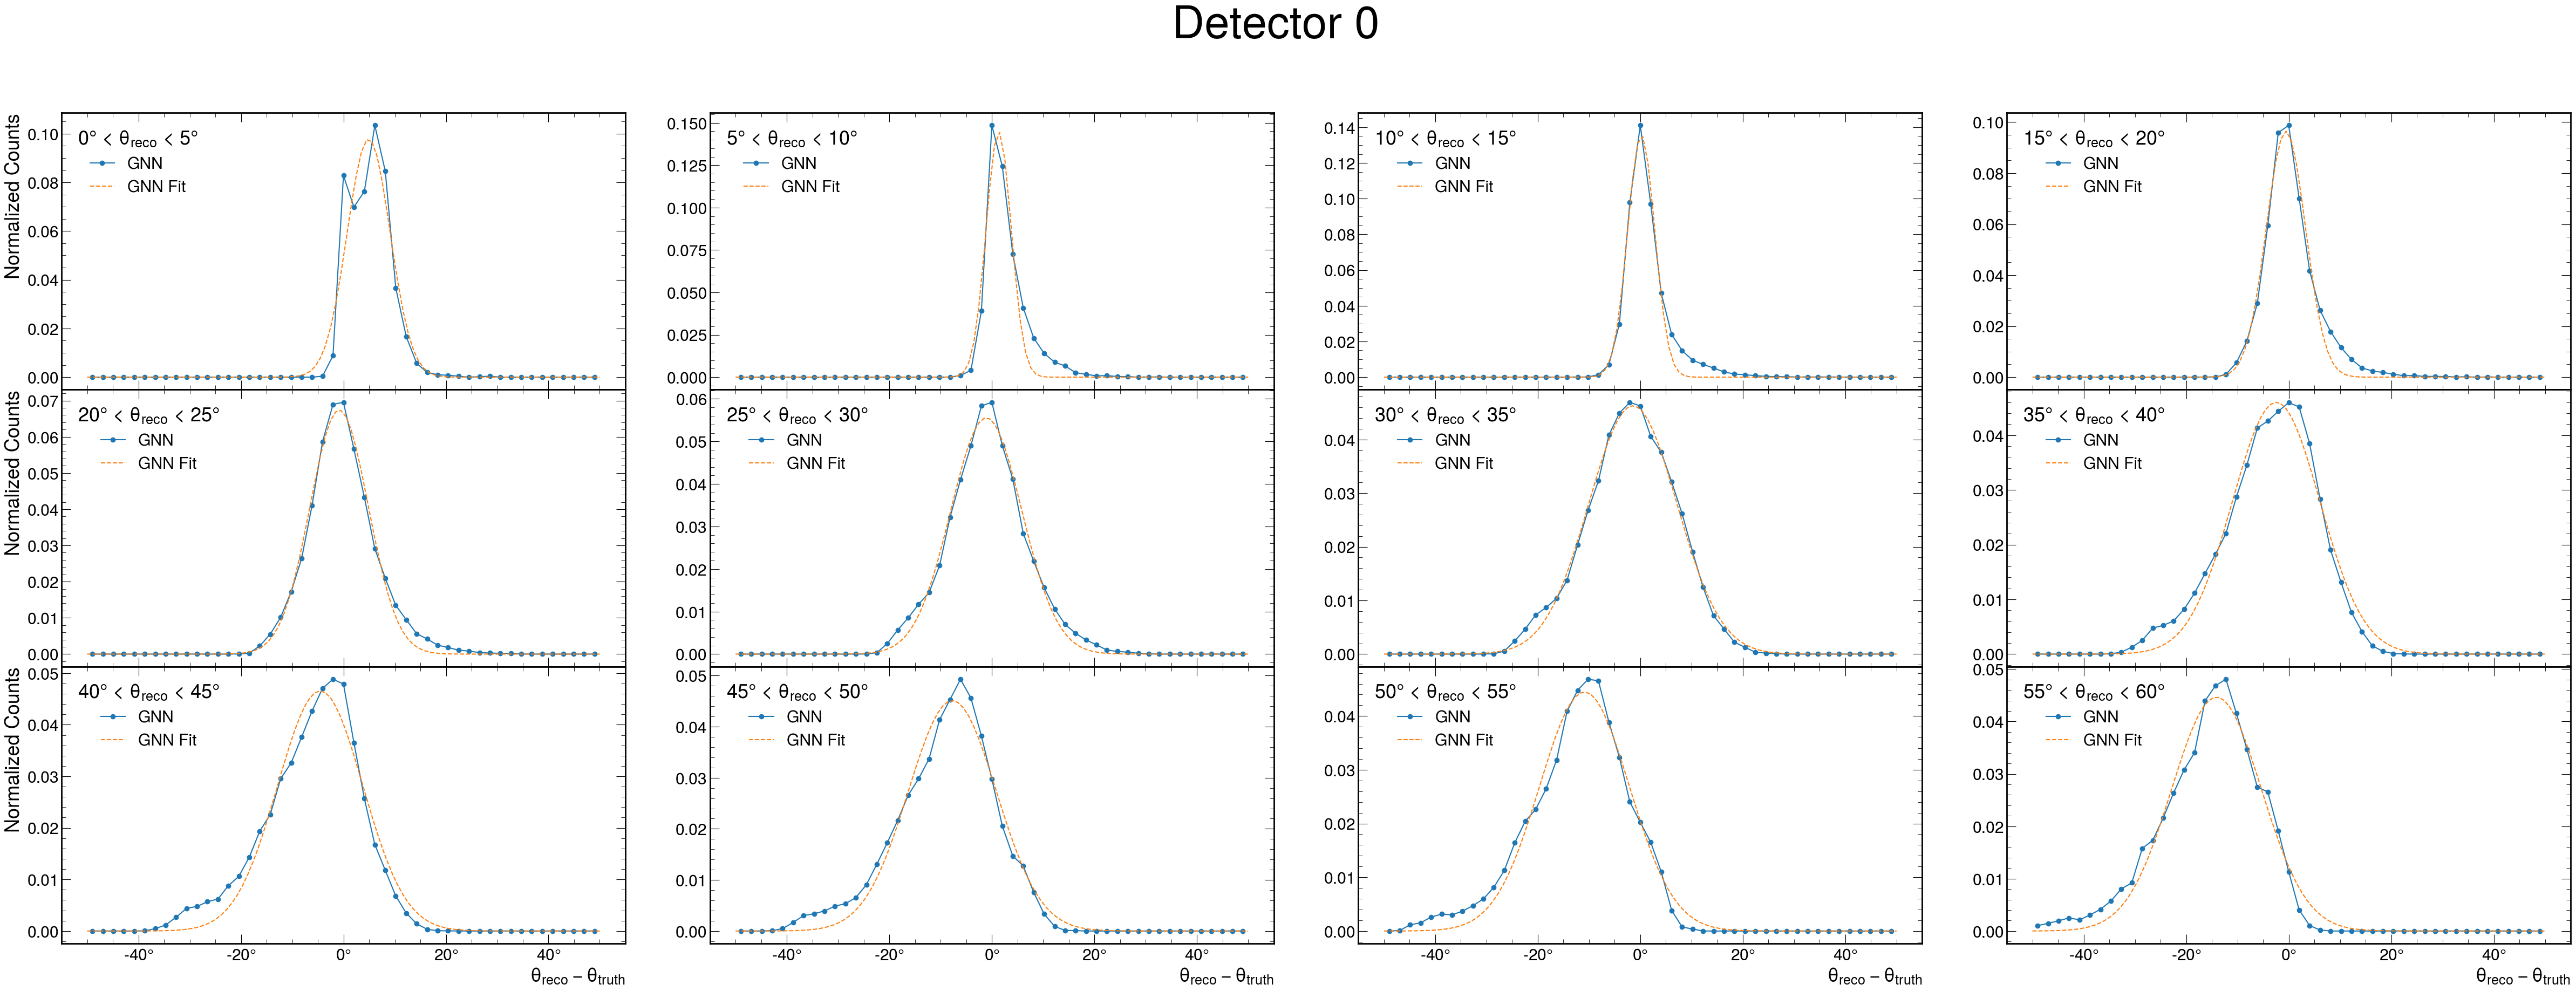

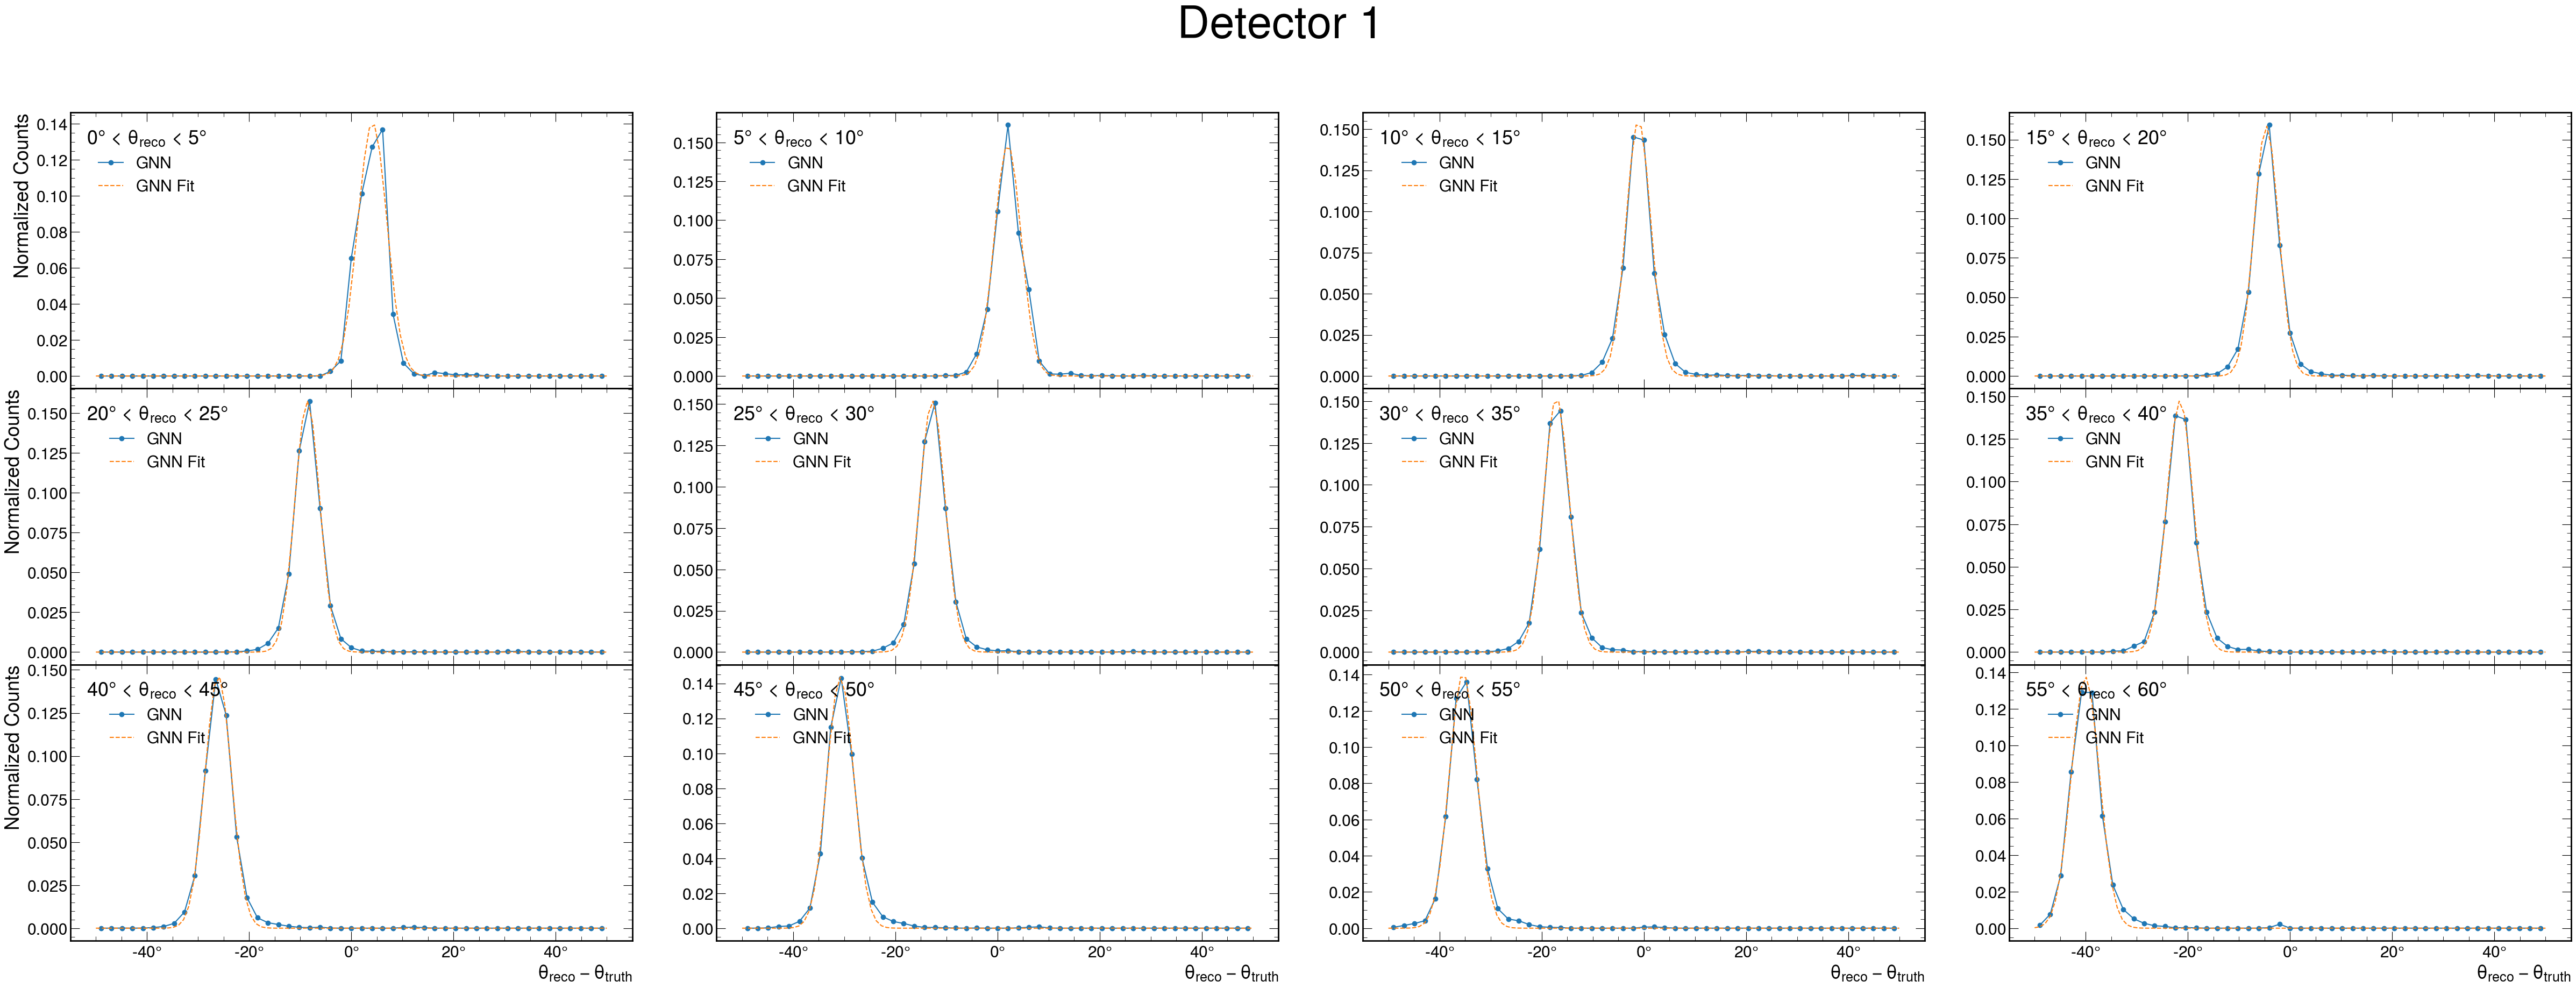

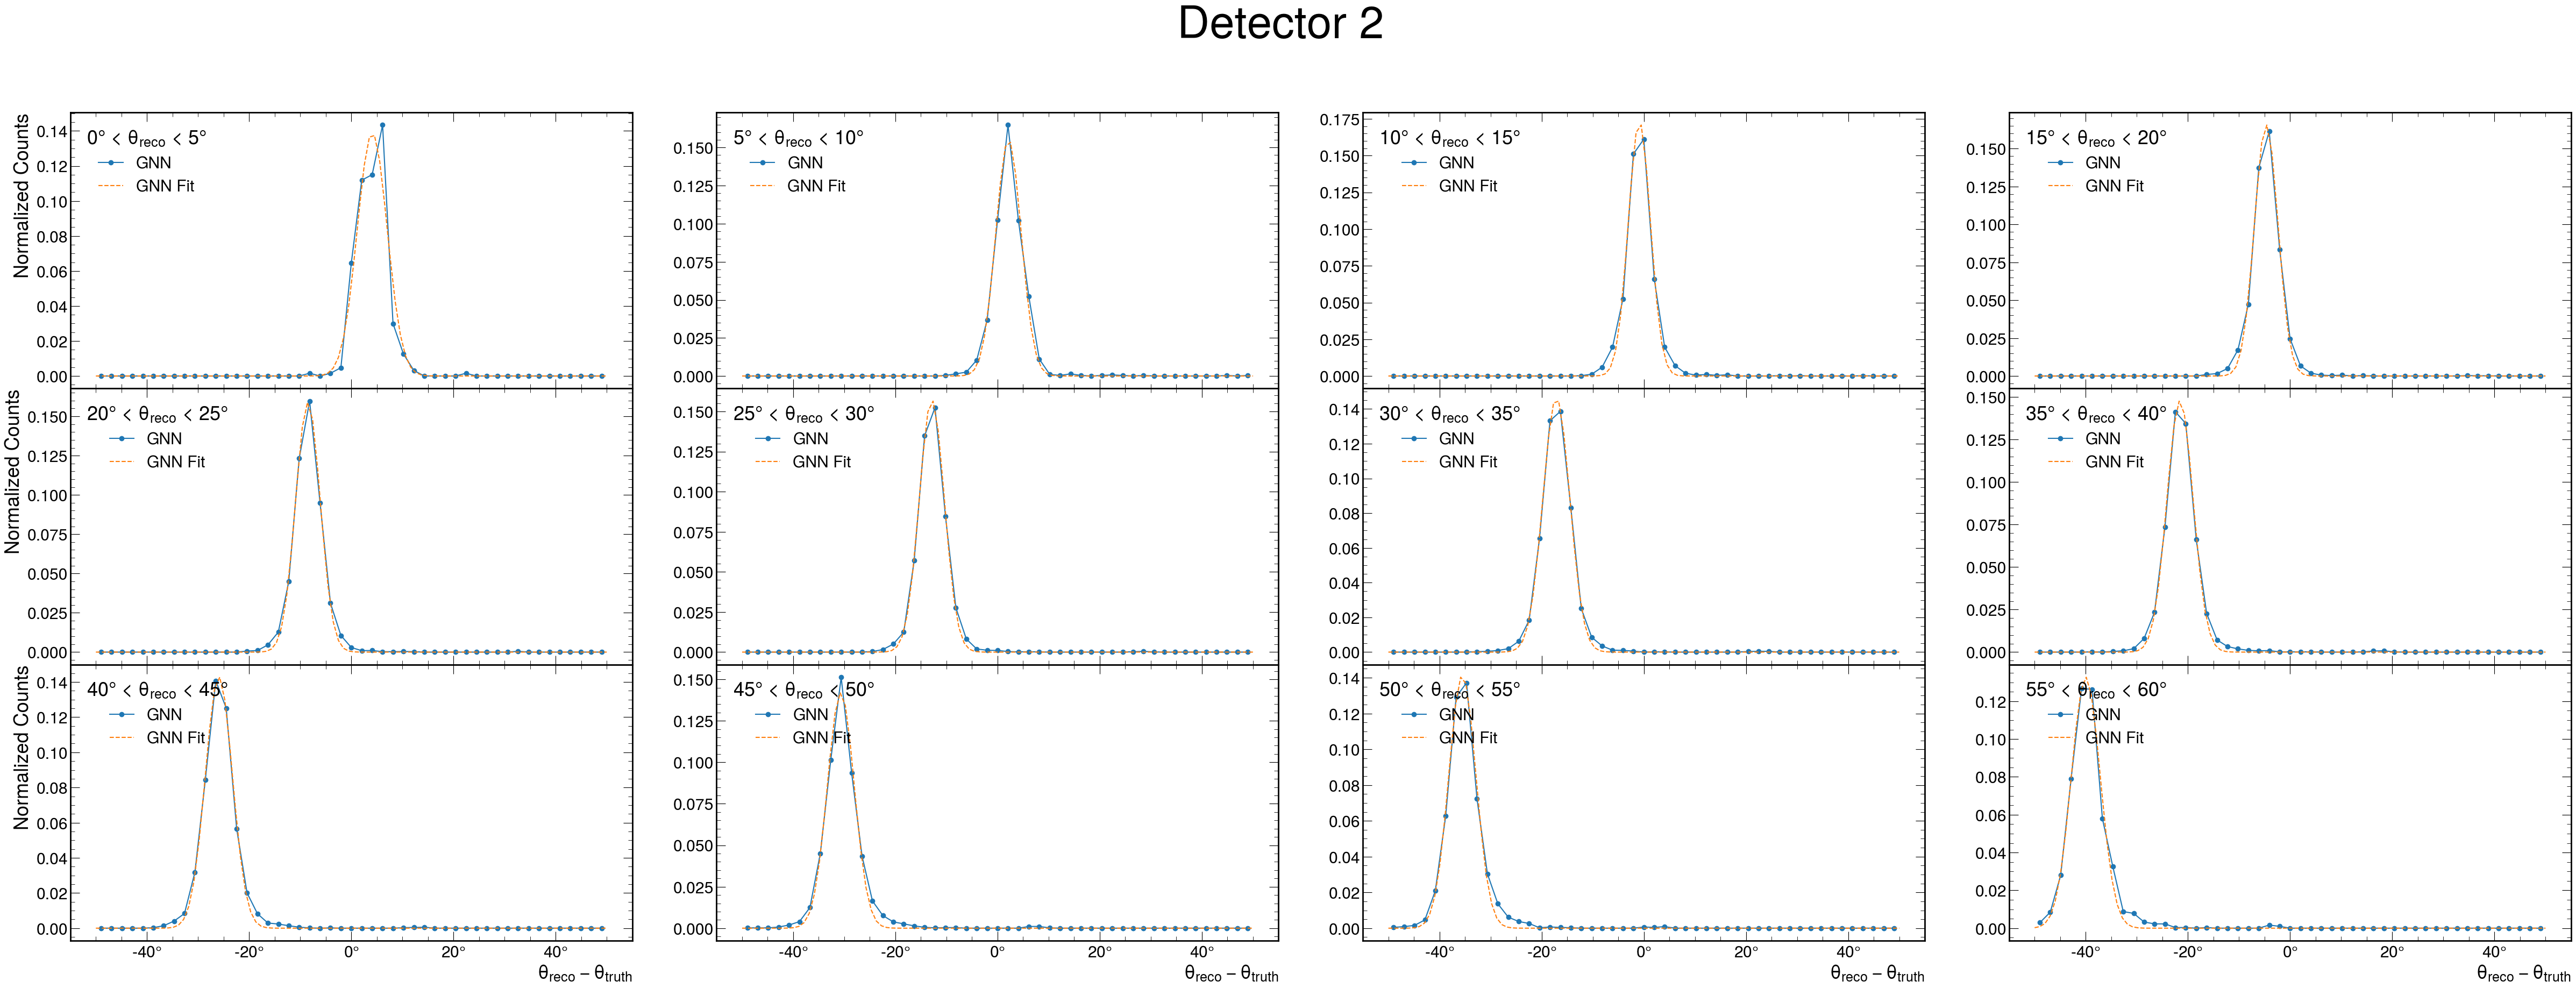

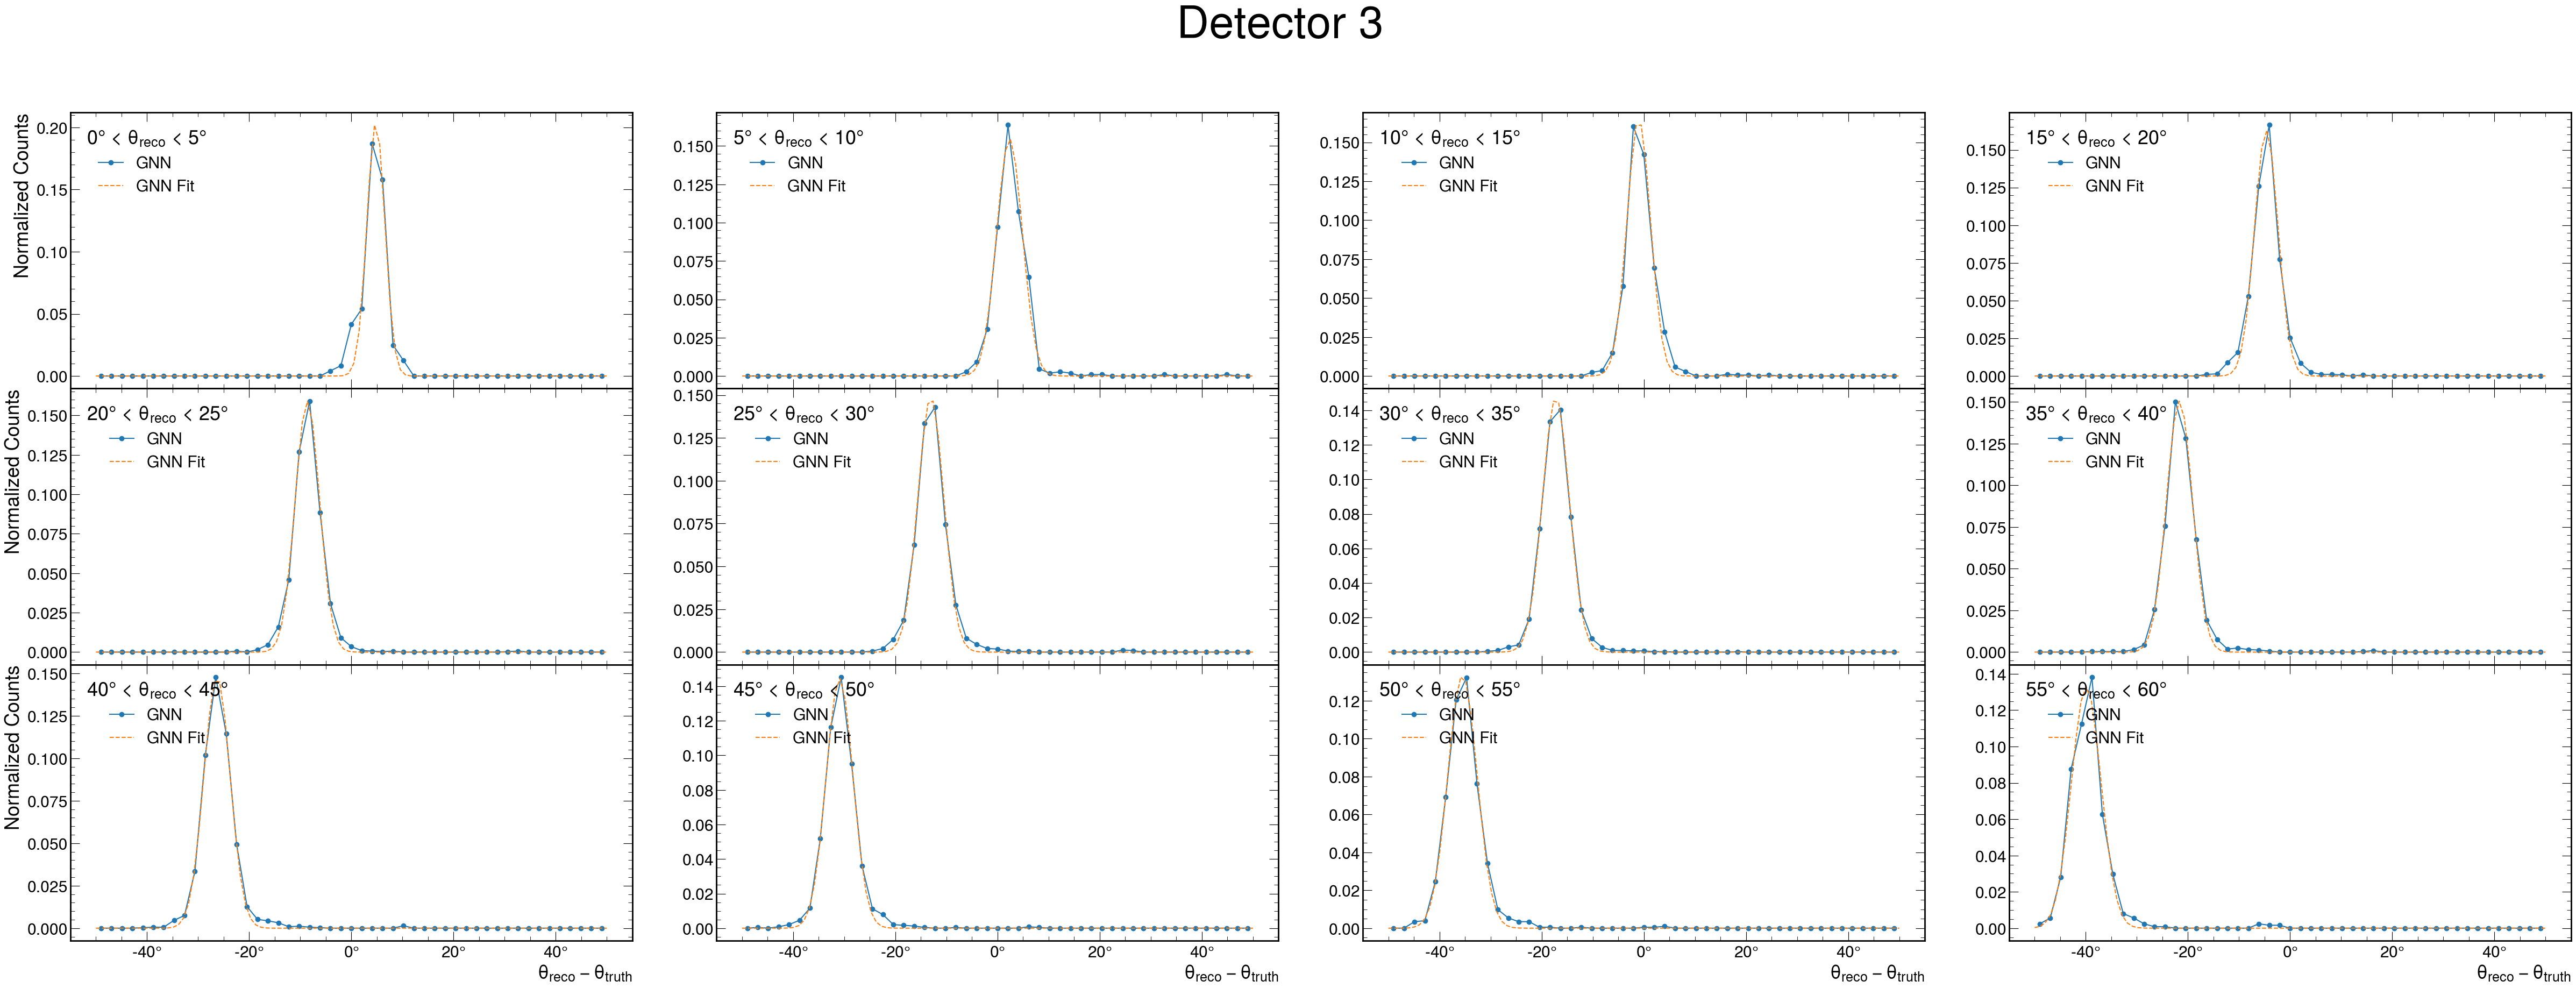

In [197]:
def theta_from_energy(E, A, k, C):
    return -(1.0 / k) * np.log((E - C) / A)
    
binsize = 5
bins= []
rms = []
mea = []
fits = []
error = []
binnum = np.linspace(-50,50,50)
max_bin = 65
for j in range(4):
    fig, ax = plt.subplots(3,4,figsize=(60,20),sharex=True,sharey=False)

    for i in range(12):
        plt.sca(ax[i//4,i%4])
        bins.append(i*binsize+5+binsize/2)
        detector_cut = dg['detector']==j
        cut = (((i) * binsize <= dg['theta_true'][detector_cut]) & (dg['theta_true'][detector_cut] < (i+1) * binsize))
        y,x = np.histogram(dg['GNN_theta'][detector_cut][cut]-dg['theta_true'][detector_cut][cut],bins=binnum,density=True)
        bc=(x[1:]+x[:-1])/2
        plt.errorbar(bc,y, fmt='-o',label='GNN')
        means = dg['GNN_theta'][detector_cut][cut]-dg['theta_true'][detector_cut][cut]
        rms.append(np.std(means))
        mea.append(np.mean(means))
        
        coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,100))
        fits.append(coeff)
        error.append(covar[2][2])
        x=np.linspace(-50,50,100)
        plt.errorbar(x,gaus(x,*coeff),fmt='--',label='GNN Fit')
    
        plt.xlabel(r'$\theta_{reco} - \theta_{truth}$')
        plt.legend(title=rf'{i * binsize}$\degree$ < $\theta_{{reco}}$ < {(i+1) * binsize}$\degree$', loc = 'upper left')
        #plt.xlim(-50,50)
    fig.subplots_adjust(wspace=0.15,hspace=0)
    
    ax[0,0].set_ylabel('Normalized Counts')
    ax[1,0].set_ylabel('Normalized Counts')
    ax[2,0].set_ylabel('Normalized Counts')
    
    import matplotlib.ticker as mticker
    def degree_formatter(x, pos):
        return rf"{int(x)}$\degree$" 
    for axi in ax.flat:
        axi.xaxis.set_major_formatter(mticker.FuncFormatter(degree_formatter))
    
    #plt.savefig('ThetaResolution_differential.pdf',format='pdf')
    plt.suptitle(f'Detector {j}', fontsize=60)
    plt.show()

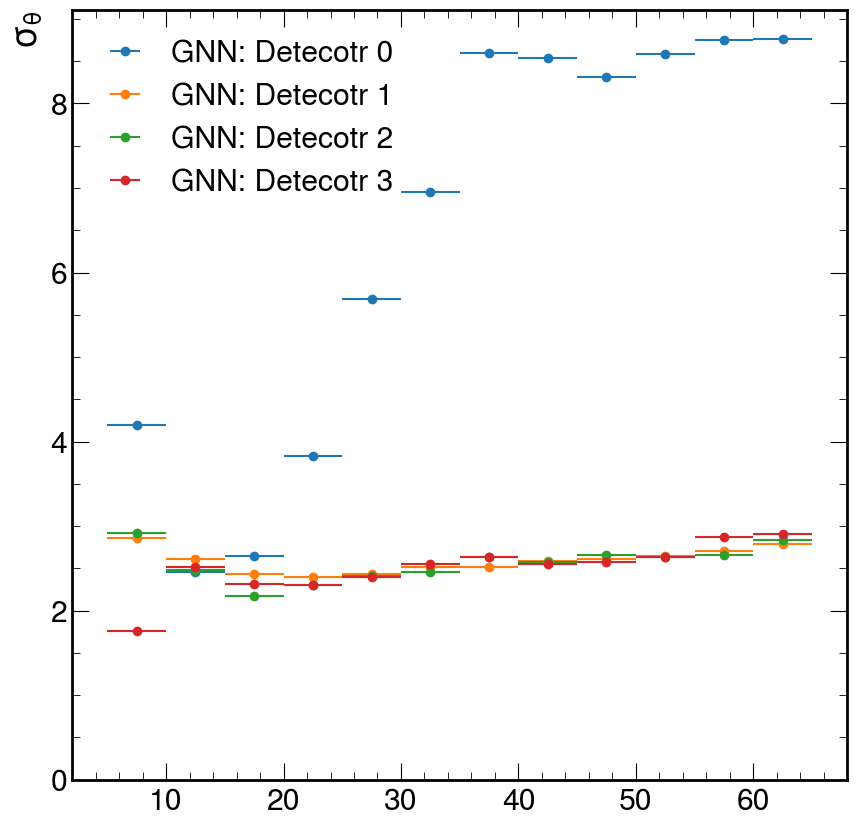

In [204]:
for j in range(4):
    plt.errorbar(bins[:12],abs(np.array(fits)[:,2][j*12:(j+1)*12]),xerr=(bins[1]-bins[0])/2,label=f'GNN: Detecotr {j}',fmt='o')

plt.ylabel(r'$\sigma_{\theta}$')
plt.ylim(bottom=0)
plt.legend()
plt.savefig('ThetaResolution_sigma.png',format='png')

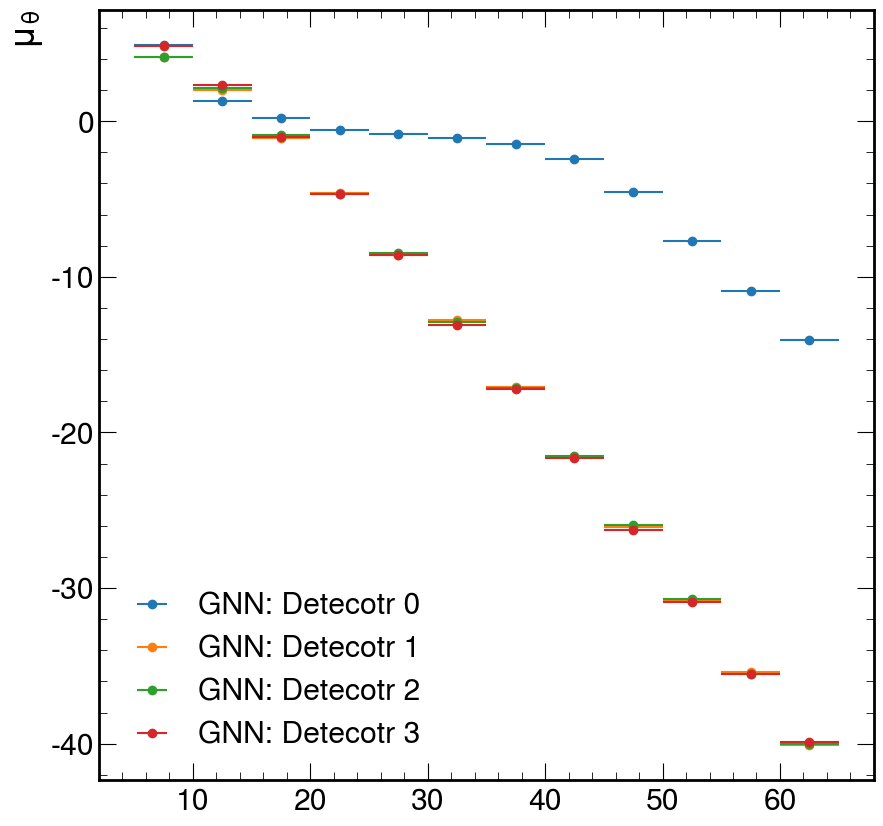

In [207]:
for j in range(4):
    plt.errorbar(bins[:12],np.array(fits)[:,1][j*12:(j+1)*12],xerr=(bins[1]-bins[0])/2,label=f'GNN: Detecotr {j}',fmt='o')

plt.ylabel(r'$\mu_{\theta}$')
#plt.ylim(bottom=0)
plt.legend()
plt.savefig('ThetaResolution_mu.png',format='png')